<a href="https://colab.research.google.com/github/ketaris/c7082_Project_KT/blob/main/c7082_KT_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 224038_Katie_Taris_c7082_Project
January 18, 2023

GitHub Repo: https://github.com/ketaris/c7082_Project_KT

Data Source: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset

## 01 BACKGROUND

One of the top conditions causing death and disease in humans is cardiovascular disease (Hartley et al., 2014). In addition to absence of exercise, heavy smoking, excessive alcohol and poor diet, a stressful lifestyle can also contribute to increased risk of cardiovascular disease (Hartley et al., 2014). Tools which can counteract these risk factors such as increasing exercise and quitting smoking could be useful to implement for all ages to avoid disease. One tool that could be used by many is yoga, as not only does it provide a form of exercise, but also aides in stress reduction and can be beneficial for hypertension (Hartley et al., 2014). 
The practice of yoga is now being researched in Mind-Body Medicine, which is an approach using many forms of interventions before or during illness (Matko et al., 2022). Research is ongoing to determine what kind of people benefit most from certain types of treatments, and if specific treatments should be assigned based on personality traits (Matko et al., 2022). While the benefits of yoga prove interesting, the next challenge is for people to fit the practice into their daily routines. Flexibility, both in time and location, helps the participant to complete yoga when convenient, but independent practice does not provide feedback on body alignment and positioning (Gajbhiye et al., 2022). Through the detection of human joints and their relative positions, computer vision could offer a potential solution to yoga practitioners. Maintaining the benefits of independent yoga practice with guided assistance to ensure correct positioning could improve yoga performance and reduce the risk of injury (Gajbhiye et al., 2022). The goal of this report is to evaluate computer vision techniques and their strengths and weaknesses in correctly identifying yoga poses with an introductory dataset. 

## 02 METHODS

Images of different yoga poses within 5 classes were used for the evaluation. 
The data source was: www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset.
The images had variations within them, including different environments, different levels of zoom, and contained a mixture of real-life photos and computer generated images. The yogis were wearing different types and colours of clothing. 
Tensorflow Keras was used, looking at a base model and some additions, as well as a YOLOv5 model. In both models there was the step of training with training data, followed by validation with validation data. 

Methods Overview:

*   2.1   Tensorflow Keras 


*   2.1.1 Pretrained model - MobileNetv2

*   2.1.2 Custom Convnet

*   2.1.3 Data Augmentation



*   2.2   YOLOv5 

### 2.1 Tensorflow Keras

###2.1.1 Pretrained model - MobileNetv2

Pretrained models are very popular and efficient in machine learning. A common model is VGG16 with 16 layers. There is also a VGG19. Here a model called MobileNetv2 was used, which is 32 times smaller than VGG16. It was noted that the pretrained model ran much faster than the other models. 

In [ ]:
!git clone https://github.com/ketaris/c7082_Project_KT.git Yoga

# setup for images
from IPython.display import Image

Cloning into 'Yoga'...
remote: Enumerating objects: 4335, done.
remote: Counting objects: 100% (1448/1448), done.
remote: Compressing objects: 100% (1340/1340), done.
remote: Total 4335 (delta 91), reused 1429 (delta 77), pack-reused 2887
Receiving objects: 100% (4335/4335), 662.78 MiB | 35.76 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [ ]:
# COLAB: directory
%cd /content/Yoga/data/Yoga_images

/content/Yoga/data/Yoga_images


In [ ]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import MobileNetV2

# Reproducability
def set_seed(seed=31415):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

# Load training and validation sets
ds_train_ = tf.keras.utils.image_dataset_from_directory(
    '/content/Yoga/data/Yoga_images/train', 
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (128, 128), 
    interpolation = 'nearest',
    batch_size = 64,
    shuffle = True,
)

ds_valid_ = tf.keras.utils.image_dataset_from_directory(
    '/content/Yoga/data/Yoga_images/valid',
    labels = 'inferred',
    label_mode='categorical',
    image_size=(128, 128), 
    interpolation = 'nearest',
    batch_size = 64,
    shuffle = False,
)

# Data Pipeline
def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
      ds_train_
      .map(convert_to_float)
      .cache()
      .prefetch(buffer_size=AUTOTUNE)
  )
ds_valid = (
      ds_valid_
      .map(convert_to_float)
      .cache()
      .prefetch(buffer_size=AUTOTUNE)
  )


Found 208 files belonging to 5 classes.
Found 204 files belonging to 5 classes.


In [ ]:
# Load pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (128, 128, 3), include_top = False,
                                                     weights = 'imagenet', pooling = 'avg')
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Attach head
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
      pretrained_model,
      layers.Flatten(),
      layers.Dense(256, activation = 'relu'),
      layers.Dense(5, activation = 'softmax')
  ])


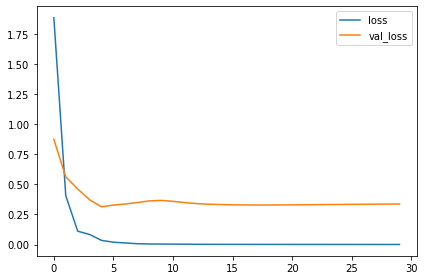

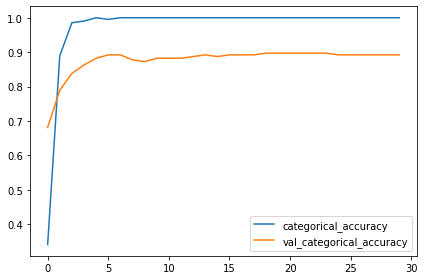

In [ ]:
# Train the model

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 30,
    verbose = 0,
)

import pandas as pd
import matplotlib.pyplot as plt


history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

plt.savefig('Basic_Tensorflow_output.png')

###2.1.2 Custom Convnet

Using layers of convolution and pooling can be used to start a model from scratch. The model has much learning to go through, compared to a pretrained model, including adjusting its weights. This model took longer to compute than the pretrained model. 

In [ ]:
# This uses layers of convolution and pooling instead of the pretrained base

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
     '/content/Yoga/data/Yoga_images/train',
     labels="inferred",
     label_mode='categorical',
     image_size=[128, 128],
     interpolation='nearest',
     batch_size=64,
     shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
     '/content/Yoga/data/Yoga_images/valid',
     labels="inferred",
     label_mode='categorical',
     image_size=[128, 128],
     interpolation='nearest',
     batch_size=64,
     shuffle=False,
)

# Data pipeline
def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 208 files belonging to 5 classes.
Found 204 files belonging to 5 classes.


In [ ]:
# Define model
# Using base of 3 layers of Conv2D and MaxPool together, with a head of flatten and 2 dense layers

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #Head
    layers.Flatten(),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=5, activation="softmax"),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)     

In [ ]:
# Train model
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=1
)

Epoch 1/40
4/4 [==============================] - 13s 3s/step - loss: 1.6097 - categorical_accuracy: 0.1971 - val_loss: 1.6007 - val_categorical_accuracy: 0.2843
Epoch 2/40
4/4 [==============================] - 10s 3s/step - loss: 1.5895 - categorical_accuracy: 0.2596 - val_loss: 1.5917 - val_categorical_accuracy: 0.2304
Epoch 3/40
4/4 [==============================] - 11s 3s/step - loss: 1.5778 - categorical_accuracy: 0.2260 - val_loss: 1.5861 - val_categorical_accuracy: 0.2304
Epoch 4/40
4/4 [==============================] - 11s 3s/step - loss: 1.5674 - categorical_accuracy: 0.2260 - val_loss: 1.5752 - val_categorical_accuracy: 0.2304
Epoch 5/40
4/4 [==============================] - 12s 3s/step - loss: 1.5503 - categorical_accuracy: 0.2404 - val_loss: 1.5615 - val_categorical_accuracy: 0.2745
Epoch 6/40
4/4 [==============================] - 10s 3s/step - loss: 1.5282 - categorical_accuracy: 0.3317 - val_loss: 1.5464 - val_categorical_accuracy: 0.3137
Epoch 7/40
4/4 [============

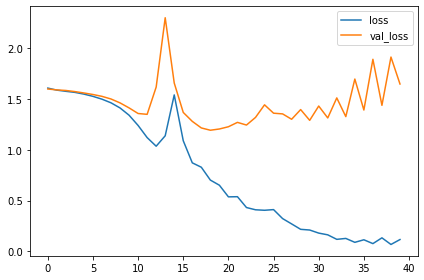

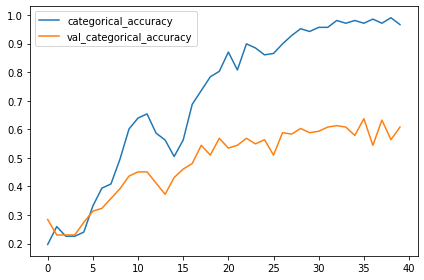

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.savefig('Custom_convnet1.png')

In [ ]:
# Add more Conv2D layers to the model to see if it improves results

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    #Head
    layers.Flatten(),
    layers.Dense(units=256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(units=5, activation="softmax"),
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)      

In [ ]:
# Train model with extra Conv2D layers
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=1
)

Epoch 1/40
4/4 [==============================] - 26s 6s/step - loss: 1.6092 - categorical_accuracy: 0.2163 - val_loss: 1.6090 - val_categorical_accuracy: 0.2108
Epoch 2/40
4/4 [==============================] - 24s 6s/step - loss: 1.6074 - categorical_accuracy: 0.2452 - val_loss: 1.6072 - val_categorical_accuracy: 0.2304
Epoch 3/40
4/4 [==============================] - 24s 6s/step - loss: 1.6042 - categorical_accuracy: 0.2548 - val_loss: 1.6051 - val_categorical_accuracy: 0.2206
Epoch 4/40
4/4 [==============================] - 25s 6s/step - loss: 1.6004 - categorical_accuracy: 0.2308 - val_loss: 1.6027 - val_categorical_accuracy: 0.2255
Epoch 5/40
4/4 [==============================] - 26s 6s/step - loss: 1.5979 - categorical_accuracy: 0.2260 - val_loss: 1.6005 - val_categorical_accuracy: 0.2304
Epoch 6/40
4/4 [==============================] - 24s 6s/step - loss: 1.5971 - categorical_accuracy: 0.2260 - val_loss: 1.5985 - val_categorical_accuracy: 0.2304
Epoch 7/40
4/4 [============

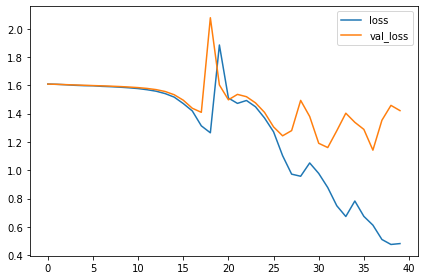

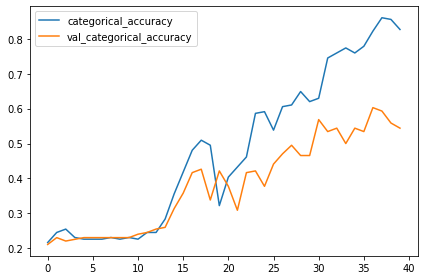

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.savefig('Custom_convnet2.png')

### 2.1.3 Data Augmentation

A model can always be improved with more training data, but there are realistic limitations to how much is available. We know that some of the available data must also be kept for validation after training. Data augmentation provides a way to get more out of the available data by changing the images in different ways in order to give the model more information and hopefully increase its learning of the dataset. Three types of data augmentation were used: horizontal flipping, contrasting, and widening the images. 

In [ ]:
# Add data augmentation to increase data set
# Completed with the GPU to speed up training

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

#Reproducability
def set_seed(seed=31415):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 

In [ ]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
     '/content/Yoga/data/Yoga_images/train',
     labels="inferred",
     label_mode='categorical',
     image_size=[128, 128],
     interpolation='nearest',
     batch_size=64,
     shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
     '/content/Yoga/data/Yoga_images/valid',
     labels="inferred",
     label_mode='categorical',
     image_size=[128, 128],
     interpolation='nearest',
     batch_size=64,
     shuffle=False,
)

# Data pipeline
def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 208 files belonging to 5 classes.
Found 204 files belonging to 5 classes.


In [ ]:
# Load pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (128, 128, 3), include_top = False,
                                                     weights = 'imagenet', pooling = 'avg')
pretrained_model.trainable = False

# Attach head
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
      preprocessing.RandomFlip('horizontal'), #vertical flip doesn't make sense
      preprocessing.RandomContrast(0.5), 
      preprocessing.RandomWidth(factor=0.15),
      pretrained_model,
      layers.Flatten(),
      layers.Dense(256, activation = 'relu'),
      layers.Dense(5, activation = 'softmax')
  ])

In [ ]:
# Train model with data augmentation
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1
)

Epoch 1/30


4/4 [==============================] - 10s 1s/step - loss: 2.0870 - categorical_accuracy: 0.1971 - val_loss: 1.8123 - val_categorical_accuracy: 0.2696
Epoch 2/30
4/4 [==============================] - 4s 1s/step - loss: 1.6883 - categorical_accuracy: 0.2885 - val_loss: 1.5470 - val_categorical_accuracy: 0.3578
Epoch 3/30
4/4 [==============================] - 4s 1s/step - loss: 1.3784 - categorical_accuracy: 0.3942 - val_loss: 1.3151 - val_categorical_accuracy: 0.4853
Epoch 4/30
4/4 [==============================] - 4s 1s/step - loss: 1.0448 - categorical_accuracy: 0.6490 - val_loss: 1.1133 - val_categorical_accuracy: 0.6176
Epoch 5/30
4/4 [==============================] - 4s 1s/step - loss: 0.7939 - categorical_accuracy: 0.8173 - val_loss: 0.9685 - val_categorical_accuracy: 0.6814
Epoch 6/30
4/4 [==============================] - 4s 1s/step - loss: 0.6247 - categorical_accuracy: 0.8750 - val_loss: 0.8428 - val_categorical_accuracy: 0.7206
Epoch 7/30
4/4 [============================

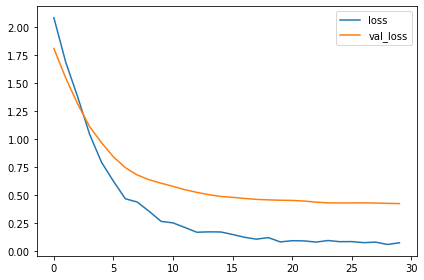

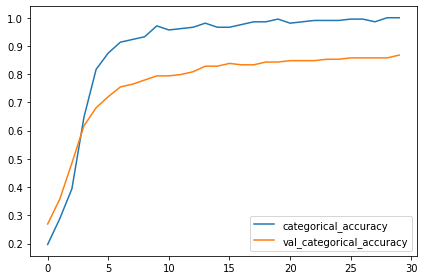

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.savefig('Data_augmentation.png')

### 2.2 YOLOv5 (Run on GPU for efficiency)

The YOLOv5 model (You Only Look Once) was used on the yoga pose images to evaluate accuracy of identification. 
Images fed into the model need to be pre-labelled with bounding boxes to identify where the image(s) are. This was done through Roboflow (roboflow.com) which also allows the user to split the images into train and valid classes (and test if desired). Through the code below, annotated images where downloaded into Google Colab for analysis. 

In [ ]:
# clone YOLOv5 repository

!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

In [ ]:
#install dependencies 
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.downloads import attempt_download

#clear output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00
Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
#get dataset (annotated) from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook='roboflow/ha-data-science/yolov5_yoga')

In [ ]:
%pwd

'/content/yolov5'

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6MNv6VhbcvTrxKeaaXjG")
project = rf.workspace().project("yolov5_yoga")
dataset = project.version(2).download("yolov5")

In [ ]:
#YAML file written by Roboflow
#loading into notebook with data

%cat /content/yolov5/Yolov5_yoga-2/data.yaml

In [ ]:
# Define model configuration
# Define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
# this is the model configuration 
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
# Customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

#parameters
nc: {num_classes}
depth_multiple: 0.33
width_multiple: 0.50

#anchors
anchors:
   -[10,13, 16,30, 33,23]
   -[30,61, 62,45, 59,119]
   -[116,90 156,198, 373,326]

#YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  
   [-1, 1, Conv, [128, 3, 2]],  
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [512, False]],  

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [256, False]],  

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [512, False]],  

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [1024, False]],  

   [[17, 20, 23], 1, Detect, [nc, anchors]],  
  ]

In [ ]:
# Train custom YOLOv5
%pwd

'/content/yolov5'

In [ ]:
# Train yolov5 on custom data for 30 epochs
# Time performance
# Run with GPU

%%time
%cd /content/yolov5/
!python train.py --img 416 --rect --batch 16 --epochs 30 --data /content/yolov5/Yolov5_yoga-2/data.yaml --weights yolov5s.pt  --cache  

In [ ]:
# Test the model
%pwd

'/content/yolov5'

In [ ]:
# Need to update the 'weights' path according to previous run(s) and source path
# 'Run' folder will appear after the first round of training

!python detect.py --weights runs/train/exp2/weights/best.pt --img 416 --conf 0.1 --source /content/yolov5/Yolov5_yoga-2/valid/images

In [ ]:
# Display results 
# Check path depending on run number

display(Image(filename='/content/yolov5/runs/train/exp/results.png'))

In [ ]:
!python /content/yolov5/val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data /content/yolov5/Yolov5_yoga-2/data.yaml --img 640

In [ ]:
# View confusion matrix
# Change path according to 'results saved' location as stated in previous line of execution 
display(Image(filename='/content/yolov5/runs/val/exp4/confusion_matrix.png'))

## 03 RESULTS

The models output graphs which can demonstrate model performance and allow analysis of the model performance. 

In [ ]:
from IPython.display import Image, clear_output
display(Image(filename='Basic_Tensorflow_output.png'))

Using the basic Tensorflow model set for 30 epochs, we can see from the image above that significant gains were made after 5 epochs. This is a signal of how quickly the pretrained base learns and after only a few epochs it is using its previous knowledge to quickly learn from its new dataset. The categorical accuracy and the validation accuracy both plateau after around 5 epochs. The validation accuracy hovers between 0.85 and 0.9. Since the validation accuracy is not decreasing after 30 epochs there has not been enough time for the model to start overfitting and reading too much noise from the training set. 

In [ ]:
from IPython.display import Image, clear_output
display(Image(filename='Custom_convnet1.png'))
display(Image(filename='Custom_convnet2.png'))

The figures above show the output of a custom convnet with three blocks of a conv2D and maxpool2D layer. The highest validation categorical accuracy reached was 0.64. The categorical accuracy went between 0.9 - 1.0. When more layers were added to the second and third blocks of the network, the computing time took almost 4 times as long (6 minutes vs. 22 minutes) and the highest validation categorical accuracy was 0.60. The categorical accuracy was above 0.8, but did not stay above 0.9. The addition of these extra layers and the extra computing time lowers the desired result and therefore does not contribute in a beneficial manner. 

In [ ]:
from IPython.display import Image, clear_output
display(Image(filename='Data_augmentation.png'))

The data augmentation showed a clear improvement to the model output. This model change was performed while using a pretrained base. Beginning with two adaptations of horizontal flip and contrast at 10 epochs, the validation categorical accuracy reached 0.82. At 30 epochs it reached 0.90. When the extra change of width was added, the highest validation categorical accuracy was 0.87. The image above shows output when all three were used. 

In [ ]:
# View confusion matrix
# Change path according to 'results saved' location as stated in previous line of execution 
display(Image(filename='/content/yolov5/runs/val/exp4/confusion_matrix.png'))

The confusion matrix produced from the YOLOv5 results show many background false negatives and only some proper identifications. Examining a selection of the output images from this model, it was apparent that there were also mis-identifications along with correct predictions. The correct predictions made by the model were done with high certainty, and the incorrect predictions were done with low certainty. Worse would be if the model was very certain about an incorrect prediction. 

## 04 DISCUSSION

There are many parameters than can be adapted in both models presented. Based on the results thus far, the pretrained base appeared to have great advantages over the custom-made network, even with the addition of layers. The learning time was faster and the computing time was lower. Many more adaptations can be made, including finding the ideal number of epochs using early stopping upon assessment of plateaued gains. Data augmentation with the pretrained model proved useful, and also had many more parameters that could be adjusted. Augmentations to the data should be done wisely in order to contribute appropriately. For example, a vertical flip of the data will yield a yoga pose done upside down which is not realistic. 
For the amount of data provided, the pretrained base on the Tensorflow model yielded better results than the YOLOv5. The latter model also has the extra step of creating bounding boxes on the images as a preprocessing step before analysis, adding extra time. As YOLO is a promising method in machine learning, it is worth testing again with more images. Some models of this type use more than 3000 images, showing the amount of data needed. 
In this analysis we tested the models on 5 classes of yoga poses. In reality, there are many more than that and with the goal being assisting a yoga practicioner at home, their practice would be consisting of more than 5 different poses. If more data were given per class, the YOLO model might prove advantageous to allocate to so many different classes. 
Once such a model was produced, the future use of such predictions would need to feedback to the participant. This could perhaps be done through an on-screen signal when they were in the correct position, a verbal affirmation, a verbal correction, or a signal coming from another device such as an Apple Watch. This would be an important next step in bringing the technology to a wide market and to be useful for people in their homes. 
People are thinking more about their health and wellbeing and how to include healthy habits, such as eating well and exercising, into their daily lives. These goals are often well-intended and sometimes hard to execute. If technology can assist the wider public in achieving part of their intentions, then it could be making very valuable contributions to many people.  

## 05 LITERATURE

Gajbhiye, R., Jarag, S., Gaikwad, P. and Koparde, S., 2022. AI Human Pose Estimation: Yoga Pose Detection and Correction. International Journal of Innovative Science and Research Technology.

Hartley, L., Dyakova, M., Holmes, J., Clarke, A., Lee, M.S., Ernst, E. and Rees, K., 2014. Yoga for the primary prevention of cardiovascular disease. Cochrane Database of Systematic Reviews, (5).

Matko, K., Berghöfer, A., Jeitler, M., Sedlmeier, P. and Bringmann, H.C., 2022. Who benefits most? Interactions between personality traits and outcomes of four incremental meditation and yoga treatments. Journal of Clinical Medicine, 11(15), p.4553.
